In [1]:
# Connect to the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import datetime
import pathlib
import random
import time
import sys
import os 
sys.path.append("/content/drive/MyDrive/Github/face-comic-recognizer/scr")
from constants import IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, SEED
from data_util import *
from my_model import VGGModel
from tensorflow.python.client import device_lib

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
def make_datermenistic(seed=SEED):
    """
    Ensures reproducibility of the results.
    Not guaranteed with GPU.
    """
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

# (0) Data loading

In [ ]:
# Upload kaggle.json
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Kaggle"
# The dataset will be stored in Google Colab, not in Google Drive!
!pip install --upgrade kaggle
!kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2
!unzip \*.zip  
%rm *.zip
%rm -rf face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples

In [7]:
data_dir = pathlib.Path("/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela")
image_count = len(list(data_dir.glob('*/*.jpg')))

# (1) Data extraction

In [8]:
train_ds_paths, val_ds_paths, test_ds_paths = train_val_test_split(
    get_file_paths(folder_path=data_dir), 
    image_count,
    data_dir)

The train set: tf.Tensor(16000, shape=(), dtype=int64)
The validation set: tf.Tensor(2000, shape=(), dtype=int64)
The test set: tf.Tensor(2000, shape=(), dtype=int64)


In [9]:
# Create the color subsets from the file paths
train_ds = prepare_for_training(train_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE))
val_ds = prepare_for_training(val_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE))
test_ds = prepare_for_training(test_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE))

In [10]:
# Create the grayscale subsets from the file paths
train_ds_gs = prepare_for_training(train_ds_paths.map(lambda x: process_path(x, data_dir, False), num_parallel_calls=AUTOTUNE))
val_ds_gs = prepare_for_training(val_ds_paths.map(lambda x: process_path(x, data_dir, False), num_parallel_calls=AUTOTUNE))
test_ds_gs = prepare_for_training(test_ds_paths.map(lambda x: process_path(x, data_dir, False), num_parallel_calls=AUTOTUNE))

In [ ]:
show_batch_examples(train_ds, data_dir)

In [ ]:
show_batch_examples(val_ds, data_dir)

# (2) Training, hyperparameters tuning, testing

## (*) Setup

In [11]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [64]:
def plot_loss_accuracy(model, 
                       epoch,
                       size=16):

    train_loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    train_acc = model.history.history['accuracy']
    val_acc = model.history.history['val_accuracy']
    xax = range(epoch)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    ax[0].set_xlabel('Epochs', fontsize=size)
    ax[1].set_xlabel('Epochs', fontsize=size)
    ax[0].set_ylabel('Loss', fontsize=size)
    ax[1].set_ylabel('Accuracy', fontsize=size)

    ax[0].tick_params(axis='both', which='major', labelsize=size)
    ax[1].tick_params(axis='both', which='major', labelsize=size)

    ax[0].plot(xax, train_loss, label="Train")
    ax[0].plot(xax, val_loss, label="Validation")
    ax[1].plot(xax, train_acc, label="Train")
    ax[1].plot(xax, val_acc, label="Validation")

    #ax[0].set_title('Loss')
    #ax[1].set_title('Accuracy')
    ax[0].legend(prop={'size': size - 4 })
    ax[1].legend(prop={'size': size - 4 })

    fig.tight_layout()


In [12]:
# Define the checkpoint directory to store the checkpoints.
def checkpoint_save():
    checkpoint_dir = '/content/drive/MyDrive/Github/face-comic-recognizer/models/checkpoints'
    checkpoint_dir_full = os.path.join(checkpoint_dir,  datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    %mkdir {checkpoint_dir_full}
    checkpoint_prefix = os.path.join(checkpoint_dir_full, "ckpt_{epoch}")
    print("Checkpoints: " + checkpoint_prefix)
    print("-" * 15)
    return checkpoint_prefix

In [13]:
def measure_time(func):
    def wrapper():
        start = time.perf_counter()
        res = func()
        difference = time.perf_counter() - start
        print("-" * 15)
        print(f"Time of execution: {round(difference, 3)}")
        print(device_lib.list_local_devices())
        return res
    return wrapper

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
strategy = tf.distribute.MirroredStrategy()

Num GPUs Available:  1


### (2.1) Baseline model

In [58]:
EPOCHS = 12

In [59]:
LEARNING_RATE = 1e-3
DROPOUT_RATE = 2e-1

In [60]:
def vgg_compile_distributed(func):
    def optimize_performance(lr, drop_rate):
        print("Don't forget to switch to GPU :)")
        print("-" * 15)
        with strategy.scope():
            f = func(lr, drop_rate)
        return f
    return optimize_performance

In [61]:
@vgg_compile_distributed
def vgg_compile(lr, drop_rate):
    make_datermenistic()
    model = VGGModel(2, drop_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                 metrics=['accuracy'])
    return model

In [62]:
@measure_time
def train_test(lr=LEARNING_RATE, 
               drop_rate=DROPOUT_RATE, 
               ep=EPOCHS, 
               bs=BATCH_SIZE):
    
    path = '/content/drive/MyDrive/Github/face-comic-recognizer/models/saved_models'
    full_path = os.path.join(path, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    %mkdir {full_path}

    model = vgg_compile(lr, drop_rate)
    
    callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save(),
                                       save_weights_only=True)]
    model.fit(train_ds_gs, 
              validation_data=val_ds_gs,
              epochs=ep,
              batch_size=bs,
              callbacks=callbacks)
    
    model.save(full_path, save_format='tf')

    return model


In [63]:
baseline_model = train_test()

Don't forget to switch to GPU :)
---------------
Checkpoints: /content/drive/MyDrive/Github/face-comic-recognizer/models/checkpoints/20221210-172448/ckpt_{epoch}
---------------
Epoch 1/12
500/500 [==============================] - 72s 135ms/step - loss: 0.2252 - accuracy: 0.9839 - val_loss: 10.3879 - val_accuracy: 0.4910
Epoch 2/12
500/500 [==============================] - 66s 131ms/step - loss: 0.0109 - accuracy: 0.9964 - val_loss: 4.8834e-04 - val_accuracy: 0.9995
Epoch 3/12
500/500 [==============================] - 65s 131ms/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 0.8504 - val_accuracy: 0.7770
Epoch 4/12
500/500 [==============================] - 65s 131ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0116 - val_accuracy: 0.9960
Epoch 5/12
500/500 [==============================] - 65s 131ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0547 - val_accuracy: 0.9870
Epoch 6/12
500/500 [==============================] - 65s 130ms/step - loss: 0.0109 - accura

---------------
Time of execution: 795.457
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14229315486976324124
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5256354563147095092
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


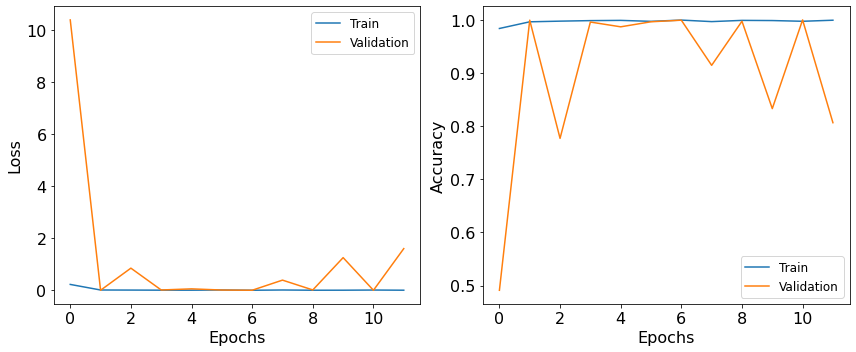

In [65]:
plot_loss_accuracy(baseline_model)

In [66]:
baseline_model.evaluate(test_ds_gs)

63/63 [==============================] - 3s 41ms/step - loss: 1.5699 - accuracy: 0.8130


[1.5699176788330078, 0.8130000233650208]

### (2.2) Hyperparameters optimization

https://www.tensorflow.org/decision_forests/tutorials/automatic_tuning_colab